In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az

sns.set()

### set this to determine what data to process

####### NOTE !!!!! ##########
#############################
### since 2020-04-23 US states no longer work since CSSE changed their format ####
### FIXED sometime early may !#### 

#############################
#############################

US_states = False

### 
### MUST RUN create_world_df_for_regression FIRST!!!!! 
World_countries = True
### 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#### US STATES SPECIFIC FRAME ####

if US_states:
    
    title = 'US States'
    dick = pd.read_pickle('us_state_dict.pkl')


    states_timeline = pd.DataFrame()
    for state,timeline in dick.items():
        temp = pd.DataFrame(data=timeline,index=timeline.index).reset_index()
        temp['state'] = state
        states_timeline = pd.concat([states_timeline,temp])

    states_timeline['density2'] = states_timeline['density'].copy() * -1 * np.random.lognormal(0.1,0.01) # to do test regression on itself
    states_timeline['conf_log'] = np.log10(states_timeline['confirmed'])
    states_timeline['dead_log'] = np.log10(states_timeline['deceased'])
    states_timeline['density_log'] = np.log10(states_timeline['density'])

    states_timeline.replace(np.inf,np.nan,inplace=True)
    states_timeline.dropna(inplace=True)

    states_timeline

In [3]:
if US_states:
    us_abb = pd.read_csv('us_states.csv',sep=';',header=None,index_col=0,usecols=[0,3],names=['state','abb'])


if World_countries:
    
    world_pop = pd.read_csv('world_pop.csv',sep=';',header=None,thousands=',',index_col=0,names=['pop'])
    
    world_lat_lon = pd.read_csv('world_lat_lon.csv',sep='\t',index_col=3)
    
    world_facts = pd.read_pickle('world_facts.pkl')
    us_abb = pd.DataFrame(world_facts['abb'])
    world_facts['density_log'] = np.log10(world_facts['density'])
    world_facts = world_facts.join(world_lat_lon['lat'])
    world_facts['lat'] = np.abs(world_facts['lat'])
    world_facts['lat_log'] = np.log10(world_facts['lat'])
    world_facts = world_facts.join(world_pop)
    world_facts['dead_per_M'] = world_facts['deceased'] /(world_facts['pop'] / 1e6)
    world_facts['dead_per_M_log'] = np.log10(world_facts['dead_per_M'])
    print (world_facts.loc['Sweden'])
    print (world_facts.describe())


confirmed               85045
factor                1.00891
inc                       751
deceased                 5787
dead_factor           1.00069
dead_inc                    4
pct_dead              6.80463
conf_log              4.92965
dead_log              3.76245
density               22.4281
pop2020           1.00993e+07
area                   450295
gdp                     54075
median_age               41.2
abb                        SE
density_log           1.35079
gdp_log                 4.733
GDP_tot           5.46118e+11
gini                     24.9
gdp_cat                     4
lat                   60.1282
lat_log               1.77908
pop               1.00993e+07
dead_per_M            573.012
dead_per_M_log        2.75816
Name: Sweden, dtype: object
          confirmed      factor           inc       deceased  dead_factor  \
count  1.510000e+02  151.000000    151.000000     151.000000   151.000000   
mean   1.437823e+05    1.011434   1372.814570    5106.629139     1.0

In [4]:
world_facts.loc[world_facts['abb'] == 'SE']

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_log,dead_log,density,...,density_log,gdp_log,GDP_tot,gini,gdp_cat,lat,lat_log,pop,dead_per_M,dead_per_M_log
Sweden,85045.0,1.008909,751.0,5787.0,1.000692,4.0,6.804633,4.929649,3.762453,22.4281,...,1.350792,4.732997,5.461178e+11,24.9,4,60.128161,1.779078,10099265.0,573.011996,2.758164


In [5]:
#### US STATES SPECIFIC FRAME ####
if US_states:
    df = pd.DataFrame()

    def get_latest_numbers(df,statename):
        state = dick[statename]
        last_row = pd.DataFrame(state.iloc[-1]).T
        last_row['state'] = statename
        df = pd.concat([df,last_row],axis=0)
        return df

    for key,data in dick.items():
        df = get_latest_numbers(df,key)
    
    #df.sort_values('dead_per_M',inplace=True,ascending=False)
    df.head(40)
    #df.to_pickle('US_states_latest_day.pkl')


In [6]:


us_age = pd.read_csv('us_states_age.csv',sep=r'\t',header=None,engine='python',usecols=[1,2],
                     names=['state','median_age'],index_col=0)

us_age.index = us_age.index.str.strip()
us_age

,median_age
state,
Maine,44.9
New Hampshire,43.0
Vermont,42.8
West Virginia,42.7
Florida,42.2
Puerto Rico,41.5
Connecticut,41.0
Pennsylvania,40.8
Delaware,40.7


In [7]:
if US_states:
    #us_df = pd.read_pickle('US_states_latest_day.pkl')
    us_df = df
    us_df['gdp_per_capita'] = us_df['gdp']
    us_df['density2'] = us_df['density'].copy() * -1 * np.random.lognormal(0.1,0.01) ## to test regress on itself
    us_df['conf_log'] = np.log10(us_df['confirmed'])
    us_df['dead_log'] = np.log10(us_df['deceased'])
    us_df['density_log'] = np.log10(us_df['density'])
    us_df['gdp_log'] = np.log10(us_df['gdp'])
    us_df['dead_per_M_log'] = np.log10(us_df['dead_per_M'])
    
    us_df.set_index('state',inplace=True)
    us_df = us_df.join(us_age)
    
    lat_lon = pd.read_csv('us_lat_lon.csv',sep=';',index_col=0)
    us_df = us_df.join(lat_lon)
    us_df['lat_log'] = np.log10(us_df['lat'])
    print(us_df)
    



In [8]:
#### US STATES SPECIFIC FRAME ####
if US_states:
    print (us_df.describe())

In [9]:

def regression(x1,x2,y):
    
    model = pm.Model()
    with model:
    
        beta1_mu = pm.Uniform('beta1_mu',-0.1,0.1)
        beta1_sigma = pm.Uniform('beta1_sigma',0,0.5)

        beta2_mu = pm.Uniform('beta2_mu',-0.1,0.1)
        beta2_sigma = pm.Uniform('beta2_sigma',0,0.5)

        obs_sigma = pm.Uniform('obs_sigma',0,0.5)

        alpha = pm.Uniform('alpha',-1,1)

        beta1 = pm.Normal('beta1',mu=beta1_mu, sd=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu, sd=beta2_sigma )


        if multiple_regression:
            
            linreq = x1.values * beta1 + x2.values*beta2 + alpha

        else:
            
            linreq = x1.values * beta1 + alpha

        obs = pm.Normal('obs',mu=linreq,sd=obs_sigma,observed=y)

        step1 = pm.Metropolis()
        
        trace = pm.sample(10000,step=step1,tune=10000)

        beta1_mu_post = trace['beta1_mu'][:]
        beta1_sigma_post = trace['beta1_sigma'][:]

        if multiple_regression:
            beta2_mu_post = trace['beta2_mu'][:]
            beta2_sigma_post = trace['beta2_sigma'][:]

        obs_sigma_post = trace['obs_sigma'][:]

        alpha_post = trace['alpha'][:]

        beta1_post = trace['beta1'][:]


        if multiple_regression:

            beta2_post = trace['beta2'][:]

            

            result = pd.DataFrame({'beta1_mu_post' : beta1_mu_post,
                                  'beta1_sigma_post' : beta1_sigma_post,
                                  'beta2_mu_post' : beta2_mu_post,
                                  'beta2_sigma_post' : beta2_sigma_post,
                                  'obs_sigma_post' : obs_sigma_post,
                                  'alpha_post' : alpha_post,
                                  'beta1_post' : beta1_post,
                                  'beta2_post' : beta2_post})

        else:
            result = pd.DataFrame({'beta1_mu_post' : beta1_mu_post,
                                  'beta1_sigma_post' : beta1_sigma_post,
                                  'obs_sigma_post' : obs_sigma_post,
                                  'alpha_post' : alpha_post,
                                  'beta1_post' : beta1_post})
        _= az.plot_trace(trace)
            
        print (az.summary(trace,round_to=2))
            
        
        return result







In [10]:
world_facts

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_log,dead_log,density,...,density_log,gdp_log,GDP_tot,gini,gdp_cat,lat,lat_log,pop,dead_per_M,dead_per_M_log
US,5438325.0,1.006498,35112.0,170497.0,1.002617,445.0,3.135101,6.735465,5.231717,35.3160,...,1.547972,4.777709,1.983997e+13,45.0,4,37.090240,1.569260,3.310027e+08,515.092551,2.711885
China,89441.0,1.000738,66.0,4703.0,1.000000,0.0,5.258215,4.951537,3.672375,148.2775,...,2.171075,3.935104,1.239546e+13,46.5,3,35.861660,1.554630,1.439324e+09,3.267507,0.514216
Japan,56717.0,1.011467,643.0,1112.0,1.008160,9.0,1.960611,4.753713,3.046105,334.6558,...,2.524598,4.582222,4.833171e+12,37.9,4,36.204824,1.558766,1.264765e+08,8.792150,0.944095
Germany,226700.0,1.007524,1693.0,9236.0,1.000108,1.0,4.074107,5.355452,3.965484,234.6140,...,2.370354,4.650113,3.743467e+12,27.0,4,51.165691,1.708979,8.378394e+07,110.235921,2.042323
India,2702681.0,1.020780,55018.0,51797.0,1.017203,876.0,1.916504,6.431795,4.714305,419.7617,...,2.623003,3.296665,2.732409e+12,35.2,2,20.593684,1.313734,1.380004e+09,37.533939,1.574424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
San Marino,699.0,1.000000,0.0,42.0,1.000000,0.0,6.008584,2.844477,1.623249,556.2459,...,2.745267,4.685697,1.645484e+09,NaN,4,43.942360,1.642883,3.393100e+04,1237.806136,3.092653
Gambia,1872.0,1.000000,0.0,63.0,1.000000,0.0,3.365385,3.272306,1.799341,226.0893,...,2.354280,2.828015,1.626418e+09,NaN,1,13.443182,1.128502,2.416668e+06,26.068951,1.416124
Antigua and Barbuda,93.0,1.000000,0.0,3.0,1.000000,0.0,3.225806,1.968483,0.477121,221.5588,...,2.345489,4.199344,1.549726e+09,NaN,3,17.060816,1.232000,9.792900e+04,30.634439,1.486210
Guinea-Bissau,2117.0,1.000000,0.0,33.0,1.000000,0.0,1.558810,3.325721,1.518514,54.4775,...,1.736217,2.867467,1.450417e+09,NaN,1,11.803749,1.072020,1.968001e+06,16.768284,1.224489


In [11]:
abb = pd.read_csv('three_letter_country_abb.csv',sep=';',header=None,index_col=0,usecols=[0,2],names=['country','abb3'])
world_facts = world_facts.join(abb)

In [12]:
start_date = '2020-03-01'
end_date = '2020-08-17'

url = 'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range/{}/{}'.format(start_date,end_date)

import requests
r = requests.get(url,timeout=5.0)
r.status_code

200

In [13]:
keys = pd.date_range(start_date,end_date)
keys

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11',
               '2020-08-12', '2020-08-13', '2020-08-14', '2020-08-15',
               '2020-08-16', '2020-08-17'],
              dtype='datetime64[ns]', length=170, freq='D')

In [14]:
json = r.json()
data = json['data']
countries = json['countries']

In [15]:
data_list = []

for k in keys:
    date = k.date().strftime('%Y-%m-%d')
    for c in countries:
        try:
            data_list.append((date,c,data[date][c]['confirmed'],data[date][c]['deaths'],data[date][c]['stringency']))
        except KeyError:
            pass


In [16]:
ox_df = pd.DataFrame(data_list,columns=['date','country','confirmed','dead','oxford_stringency'])
ox_df['date'] = pd.to_datetime(ox_df['date'])
ox_df = ox_df.set_index(['country','date'])
print (ox_df.head())

                    confirmed  dead  oxford_stringency
country date                                          
ABW     2020-03-01        NaN   NaN               0.00
AFG     2020-03-01        1.0   0.0              27.78
AGO     2020-03-01        NaN   NaN               8.33
AIA     2020-03-01        NaN   NaN               8.33
ALB     2020-03-01        NaN   NaN               8.33


In [17]:
ox_df = ox_df.groupby(level=0).mean()['oxford_stringency']
ox_df

country
ABW    47.904412
AFG    72.646471
AGO    69.548588
AIA    43.163706
ALB    70.232176
         ...    
VUT    60.459529
YEM    41.991941
ZAF    74.281647
ZMB    45.385353
ZWE    71.573176
Name: oxford_stringency, Length: 185, dtype: float64

In [18]:
world_facts = world_facts.join(ox_df,on='abb3')


In [19]:
world_facts = world_facts.loc[~world_facts['oxford_stringency'].isna()]
world_facts

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_log,dead_log,density,...,GDP_tot,gini,gdp_cat,lat,lat_log,pop,dead_per_M,dead_per_M_log,abb3,oxford_stringency
US,5438325.0,1.006498,35112.0,170497.0,1.002617,445.0,3.135101,6.735465,5.231717,35.3160,...,1.983997e+13,45.0,4,37.090240,1.569260,3.310027e+08,515.092551,2.711885,USA,66.069588
China,89441.0,1.000738,66.0,4703.0,1.000000,0.0,5.258215,4.951537,3.672375,148.2775,...,1.239546e+13,46.5,3,35.861660,1.554630,1.439324e+09,3.267507,0.514216,CHN,76.059235
Japan,56717.0,1.011467,643.0,1112.0,1.008160,9.0,1.960611,4.753713,3.046105,334.6558,...,4.833171e+12,37.9,4,36.204824,1.558766,1.264765e+08,8.792150,0.944095,JPN,35.668941
Germany,226700.0,1.007524,1693.0,9236.0,1.000108,1.0,4.074107,5.355452,3.965484,234.6140,...,3.743467e+12,27.0,4,51.165691,1.708979,8.378394e+07,110.235921,2.042323,DEU,61.019941
India,2702681.0,1.020780,55018.0,51797.0,1.017203,876.0,1.916504,6.431795,4.714305,419.7617,...,2.732409e+12,35.2,2,20.593684,1.313734,1.380004e+09,37.533939,1.574424,IND,77.761529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lesotho,946.0,1.047619,43.0,30.0,1.200000,5.0,3.171247,2.975891,1.477121,70.5732,...,2.641393e+09,63.2,1,29.609988,1.471438,2.142249e+06,14.003974,1.146251,LSO,64.467706
Central African Republic,4667.0,1.003224,15.0,61.0,1.000000,0.0,1.307049,3.669038,1.785330,7.7526,...,2.047821e+09,NaN,1,6.611111,0.820274,4.829767e+06,12.630009,1.101404,CAF,57.075176
Belize,475.0,1.050885,23.0,4.0,1.333333,1.0,0.842105,2.676694,0.602060,17.3138,...,1.971042e+09,NaN,2,17.189877,1.235273,3.976280e+05,10.059654,1.002583,BLZ,66.217471
San Marino,699.0,1.000000,0.0,42.0,1.000000,0.0,6.008584,2.844477,1.623249,556.2459,...,1.645484e+09,NaN,4,43.942360,1.642883,3.393100e+04,1237.806136,3.092653,SMR,57.842059


In [20]:
#################################### HERE STARTS THE GENERIC BIT #####################################

# independent1, independent2, dependent

x1_param = x1_param_org = 'lat'
x2_param = x2_param_org = 'oxford_stringency'
y_param = y_param_org = 'dead_per_M_log'

#x1_param = 'x_real'
#x2_param = 'x_spurious'
#y_param = 'y'

multiple_regression = False

outlier = 10

### REPLACE THE ASSIGNMENT TO xy BELOW WITH THE DATAFRAME YOU WANT TO RUN REGRESSION ON ###
### AND CHANGE x1_param,x2_param,y_param above to correct column names and set US_states in top frame to True/False ###

if US_states:
    xy = us_df[[x1_param,x2_param,y_param]].copy()
    title = 'US states'

if World_countries:
    xy = world_facts[[x1_param,x2_param,y_param]]
    title = 'World countries'

# THIS IS A DATASET FOR UNDERSTANDING 
if not (US_states or World_countries):
    xy = pd.read_pickle('spurious_correlation.pkl')
    
    

In [21]:
if xy.isna().any().sum():
    print ('Warning - NaN values present! DROPPING....')
    xy.dropna(inplace=True)

Warning - NaN values present! DROPPING....


<ipython-input-21-a00600b88f91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xy.dropna(inplace=True)


In [22]:
def standardize(x):
    return (x - x.mean()) / x.std()



######################################################################################################

xy[['x1_std','x2_std','y_std']] = xy.apply(standardize)

mask = (xy[['x1_std','x2_std','y_std']] > outlier).any(axis=1)

xy = (xy[~mask]).copy()

true_x1_mean = np.power(10,xy[x1_param]).mean() if ('_log' in x1_param) else xy[x1_param].mean()
true_x1_std = np.power(10,xy[x1_param]).std() if ('_log' in x1_param) else xy[x1_param].std()
true_x2_mean = np.power(10,xy[x2_param]).mean() if ('_log' in x2_param) else xy[x2_param].mean()
true_x2_std = np.power(10,xy[x2_param]).std() if ('_log' in x2_param) else xy[x2_param].std()
true_y_mean = np.power(10,xy[y_param]).mean() if ('_log' in y_param) else xy[y_param].mean()
true_y_std = np.power(10,xy[y_param]).std() if ('_log' in y_param) else xy[y_param].std()

print (xy)
print (xy.describe())

xy_orig = xy.copy()


                                lat  oxford_stringency  dead_per_M_log  \
US                        37.090240          66.069588        2.711885   
China                     35.861660          76.059235        0.514216   
Japan                     36.204824          35.668941        0.944095   
Germany                   51.165691          61.019941        2.042323   
India                     20.593684          77.761529        1.574424   
...                             ...                ...             ...   
Lesotho                   29.609988          64.467706        1.146251   
Central African Republic   6.611111          57.075176        1.101404   
Belize                    17.189877          66.217471        1.002583   
San Marino                43.942360          57.842059        3.092653   
Gambia                    13.443182          64.055824        1.416124   

                            x1_std    x2_std     y_std  
US                        0.549390  0.211069  1.503197

/usr/local/lib64/python3.8/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 49 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1        0.45  0.04    0.37     0.53        0.0      0.0   3660.00   
beta2       -0.00  0.29   -0.61     0.58        0.0      0.0   3490.32   
beta1_mu     0.01  0.06   -0.08     0.10        0.0      0.0   4025.05   
beta1_sigma  0.36  0.09    0.21     0.50        0.0      0.0   3811.92   
beta2_mu    -0.00  0.06   -0.09     0.09        0.0      0.0   2812.09   
beta2_sigma  0.25  0.14    0.03     0.49        0.0      0.0   1803.34   
obs_sigma    0.50  0.00    0.50     0.50        0.0      0.0   4300.98   
alpha        0.00  0.04   -0.08     0.08        0.0      0.0   3906.82   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3660.00   3653.41   3631.66    1.0  
beta2        2858.61   3401.64   4018.59    1.0  
beta1_mu     3633.14   3940.40   4507.23    1.0  
beta1_sigma  3729.39   3717.03   4213.87    1.0  
beta2_mu     2812.09   2913.99   3856.38    1.0  
beta2_sigma  1803.34   1785.31   

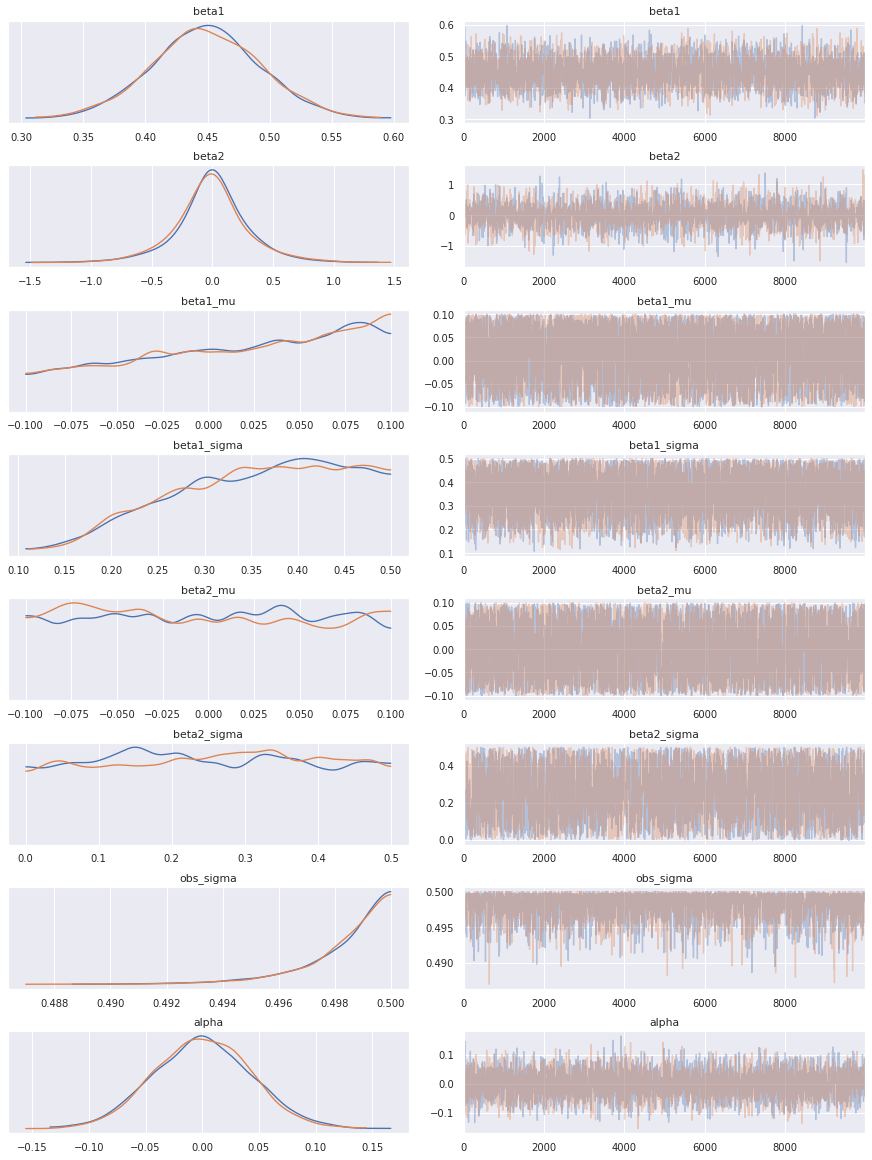

In [23]:


result = regression(xy['x1_std'],xy['x2_std'],xy['y_std'])
print ()
print ('result stats')
print (result.describe())
print()
print ('result covariance matrix')
print (result.cov())
print()
print ('result correlation coeff')
print (result.corr())

In [24]:
def plot(result,x1,x2,y,title,n,df,create_figure=True,residuals = False,color='crimson'):
    
    min_x = (np.minimum(x1,x2)).min()
    max_x = (np.maximum(x1,x2)).max()
    min_y = min(y)
    max_y = max(y)
    
    x1_mu = df[x1_param.replace('_std','')].mean()
    x1_sigma = df[x1_param.replace('_std','')].std()
    x2_mu = df[x2_param.replace('_std','')].mean()
    x2_sigma = df[x2_param.replace('_std','')].std()
    y_mu = df[y_param.replace('_std','')].mean()
    y_sigma = df[y_param.replace('_std','')].std()

    x1_param_beta = result.beta1_post.mean()
    alpha_param = result.alpha_post.mean()
    x1_param_sigma = result.beta1_post.std()
    x1_param_89 = np.percentile(result.beta1_post,[5.5,94.5])

    if multiple_regression:
    
        x2_param_beta = result.beta2_post.mean()
        x2_param_sigma = result.beta2_post.std()
        x2_param_89 = np.percentile(result.beta2_post,[5.5,94,5])

    if create_figure:
        plt.figure(figsize=(18,12))
        #plt.ylim([-outlier,outlier])

    
    plt.title ('{} {}  '.format(
        n, title))

    if not residuals:
        label1 = x1_param + \
                    r' $\beta$: {:.2f} $\alpha$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
                    x1_param_beta,alpha_param,x1_param_89[0],x1_param_89[1])
        
        if multiple_regression:
            label2 = x2_param + \
                r' $\beta$: {:.2f} $\alpha$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
                x2_param_beta,alpha_param,x2_param_89[0],x2_param_89[1])              
    else:
        
        label1 = ' '
        
    plt.scatter(x1,y, color=color, label=label1)
    
    if multiple_regression:
        plt.scatter(x2,y,color='g',label=label2)

    X = np.linspace(min_x,max_x,1000)
    
    rows = np.random.choice(result.index,replace=True,size=len(X))

    beta1_samples = result.beta1_post[rows]

    if multiple_regression:
        beta2_samples = result.beta2_post[rows]
    
    alpha_samples = result.alpha_post[rows]

    if multiple_regression:
        lines = [X[i] * beta1_samples + X[i] * beta2_samples + alpha_samples for i in range(len (X))]
        
        
        samples2 = np.array([pm.Normal.dist(X[i] * result.beta1_post[rows] + X[i] * result.beta2_post[rows] + result.alpha_post[rows],
                                      result.obs_sigma_post[rows]).random(size=len(X)) for i in range(len(X))])
        
        high2,low2 = np.percentile(samples2,[5.5,94.5],axis=1)
        
        plt.fill_between(X,high2,low2,color='orange',alpha=0.2)
        
        plt.plot(X,X * beta1_samples.mean() + X * beta2_samples.mean() + alpha_samples.mean(),color='k',ls='dashed')
        
    else:
        lines = [X[i] * beta1_samples  + alpha_samples for i in range(len (X))]
        rows = np.random.choice(result.index,replace=True,size=len(X))
        
        samples2 = np.array([pm.Normal.dist(X[i] * result.beta1_post[rows] + result.alpha_post[rows],
                                      result.obs_sigma_post[rows]).random(size=len(X)) for i in range(len(X))])
        
        high2,low2 = np.percentile(samples2,[5.5,94.5],axis=1)
        
        plt.fill_between(X,high2,low2,color='orange',alpha=0.2)
        
        plt.plot(X,X * beta1_samples.mean() + alpha_samples.mean(),color='k',ls='dashed')


    plt.plot(X,lines,alpha=0.01,color='r')

    if multiple_regression:
        plt.xlabel(x1_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ] '.format(
            x1_mu,true_x1_mean,x1_sigma,true_x1_std) + \
                   x2_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ]'.format(
            x2_mu,true_x2_mean,x2_sigma,true_x2_std))
        
        if not residuals:
            plt.ylabel(y_param + r' $\mu$: {:.2f} [ {:.2f} ] $\sigma$: {:.2f} [ {:.2f} ]'.format(
                y_mu,true_y_mean,y_sigma,true_y_std))

    
    else:
        if not residuals:
            plt.xlabel(x1_param + r' $\mu$: {:.2f} $\sigma$: {:.2f} '.format(x1_mu,x1_sigma) )
            plt.ylabel(y_param + r' $\mu$: {:.2f} $\sigma$: {:.2f}'.format(y_mu,y_sigma))
        else:
            plt.xlabel('predictor')
            plt.ylabel('other predictor residual')
        
    plt.legend(loc='upper left')
    
    if not multiple_regression:
        
        if US_states or World_countries:
            for s in xy.index:
                plt.text(x1.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
            
    else:
        if US_states or World_countries:
            for s in xy.index:
                plt.text(x1.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
                plt.text(x2.loc[s] ,y.loc[s] ,us_abb.loc[s,'abb'],color='k')
            

    filename = lambda x : x.replace(' ','_').replace('}','_').replace('{','_').replace('-','_')

    plt.savefig('linear_regression_' + filename(title) + '.jpg',format='jpg')

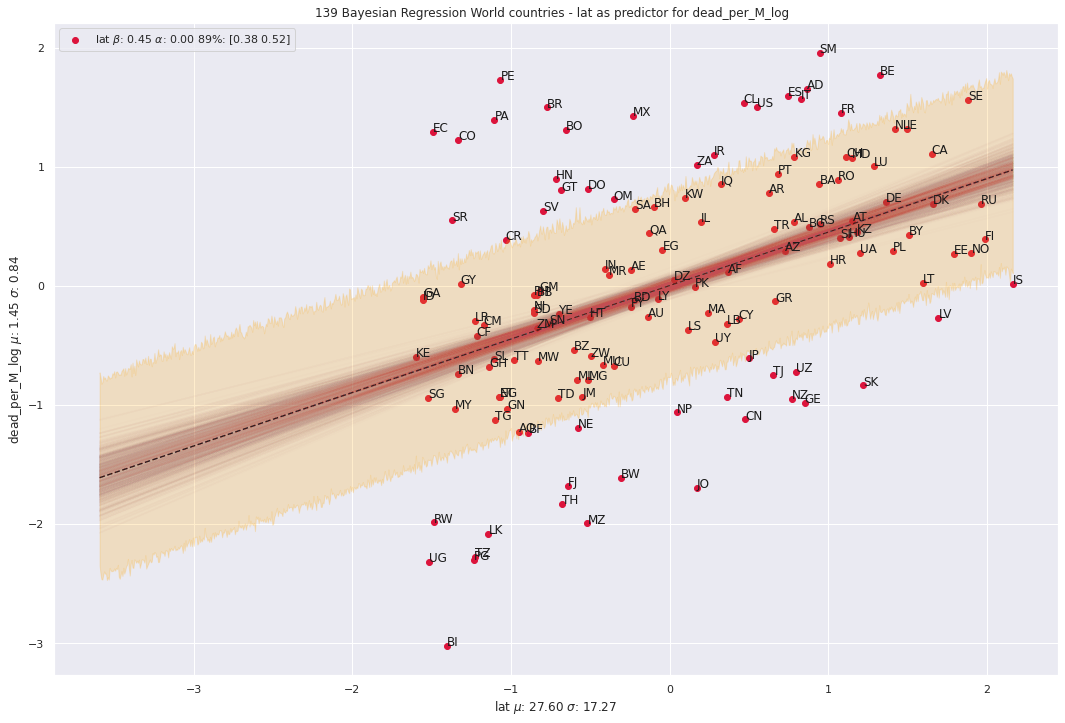

In [25]:
plot(result,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'Bayesian Regression {} - {} as predictor for {}'.format(title, x1_param,y_param),len(xy),xy)



In [26]:
print (xy.head(50))

                            lat  oxford_stringency  dead_per_M_log    x1_std  \
US                    37.090240          66.069588        2.711885  0.549390   
China                 35.861660          76.059235        0.514216  0.478240   
Japan                 36.204824          35.668941        0.944095  0.498113   
Germany               51.165691          61.019941        2.042323  1.364532   
India                 20.593684          77.761529        1.574424 -0.405964   
France                46.227638          64.196882        2.668622  1.078558   
Brazil                14.235004          71.440941        2.708093 -0.774209   
Italy                 41.871940          68.201235        2.767522  0.826309   
Canada                56.130366          64.357824        2.381020  1.652047   
Russia                61.524010          71.059412        2.031935  1.964406   
Australia             25.274398          61.827176        1.234936 -0.134893   
Spain                 40.463667         

In [27]:
def plot_betas(result,title):
    
    x1_param_beta = result.beta1_post.mean()
    alpha_param = result.alpha_post.mean()
    x1_param_sigma = result.beta1_post.std()
    x1_param_89 = np.percentile(result.beta1_post,[5.5,94.5])

    if multiple_regression:
    
        x2_param_beta = result.beta2_post.mean()
        x2_param_sigma = result.beta2_post.std()
        x2_param_89 = np.percentile(result.beta2_post,[5.5,94,5])
        
    plt.figure(figsize=(18,12))
    plt.title('Regression Betas ' + title)
    plt.hist(result.beta1_post,density=True,label=x1_param + \
                r' $\beta$: {:.2f} $\sigma$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
        x1_param_beta,x1_param_sigma,x1_param_89[0],x1_param_89[1]),
             color='r',alpha=0.7,histtype='stepfilled')

    if multiple_regression:
        plt.hist(result.beta2_post,density=True,label=x2_param + \
                    r' $\beta$: {:.2f} $\sigma$: {:.2f} 89%: [{:.2f} {:.2f}]'.format(
            x2_param_beta,x2_param_sigma,x2_param_89[0],x2_param_89[1]),
                 color='g',alpha=0.7,histtype='stepfilled')
    
    plt.legend(loc='upper left')

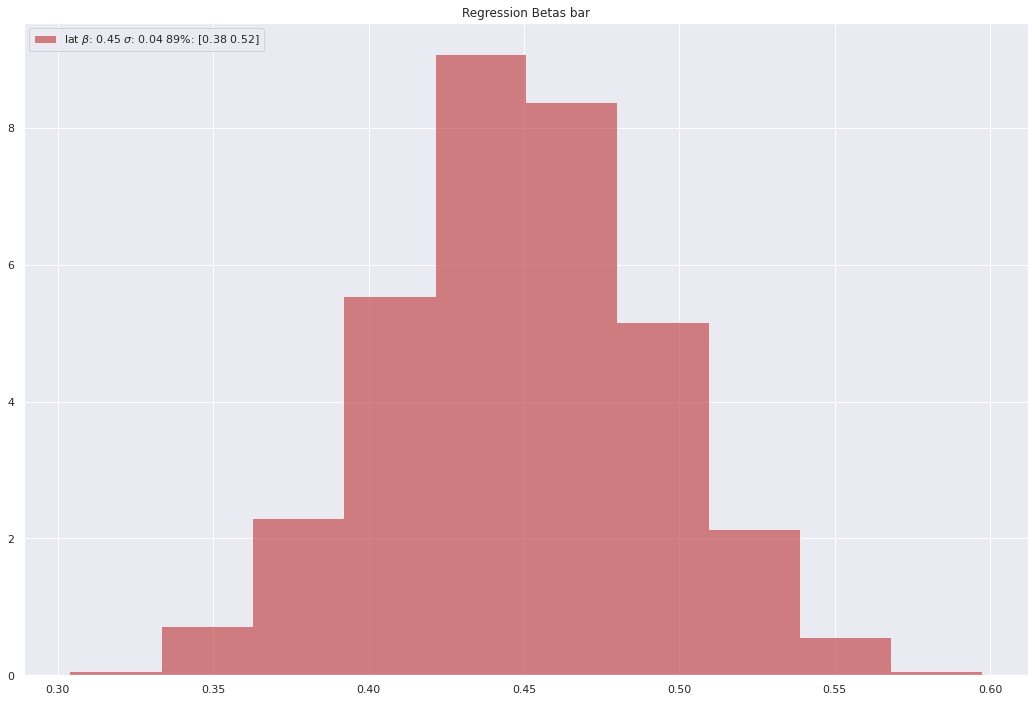

In [28]:
plot_betas(result,'bar')


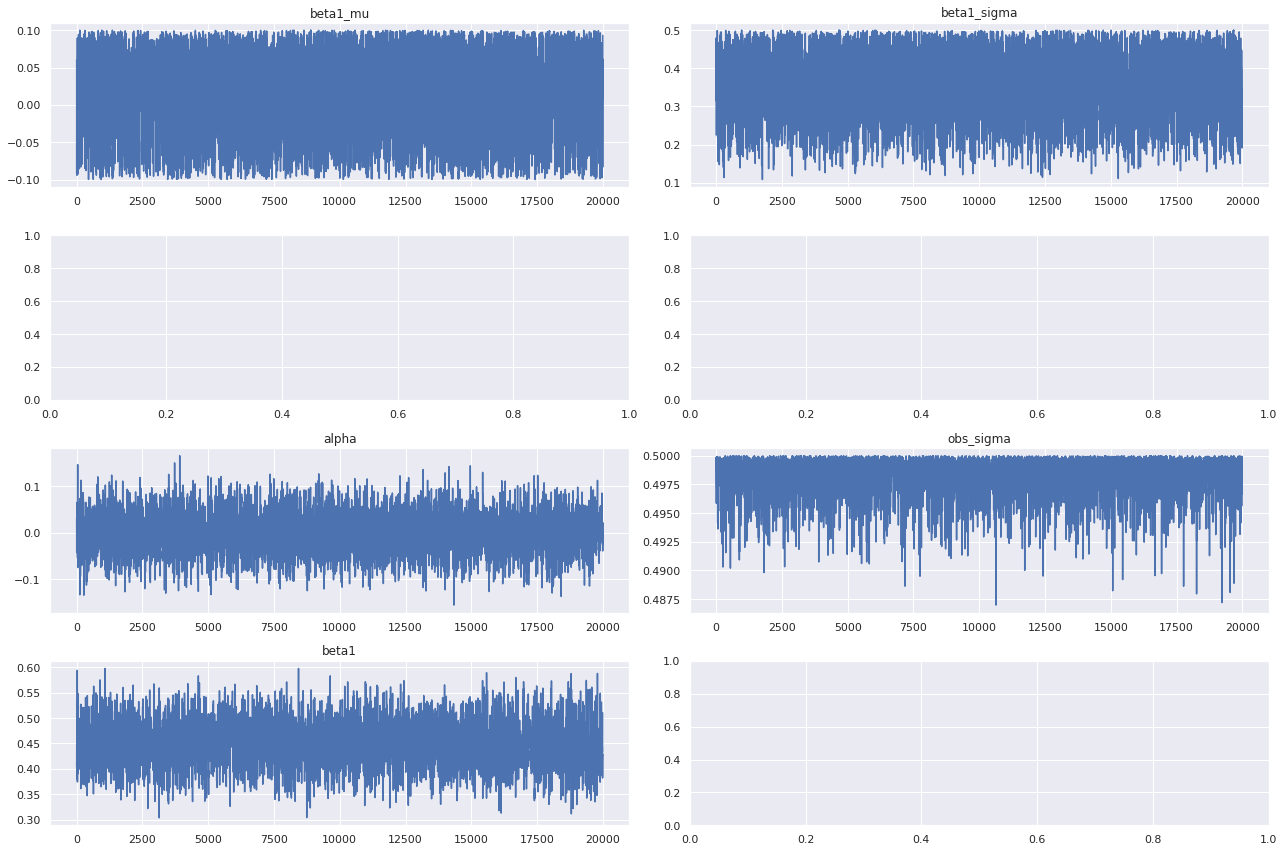

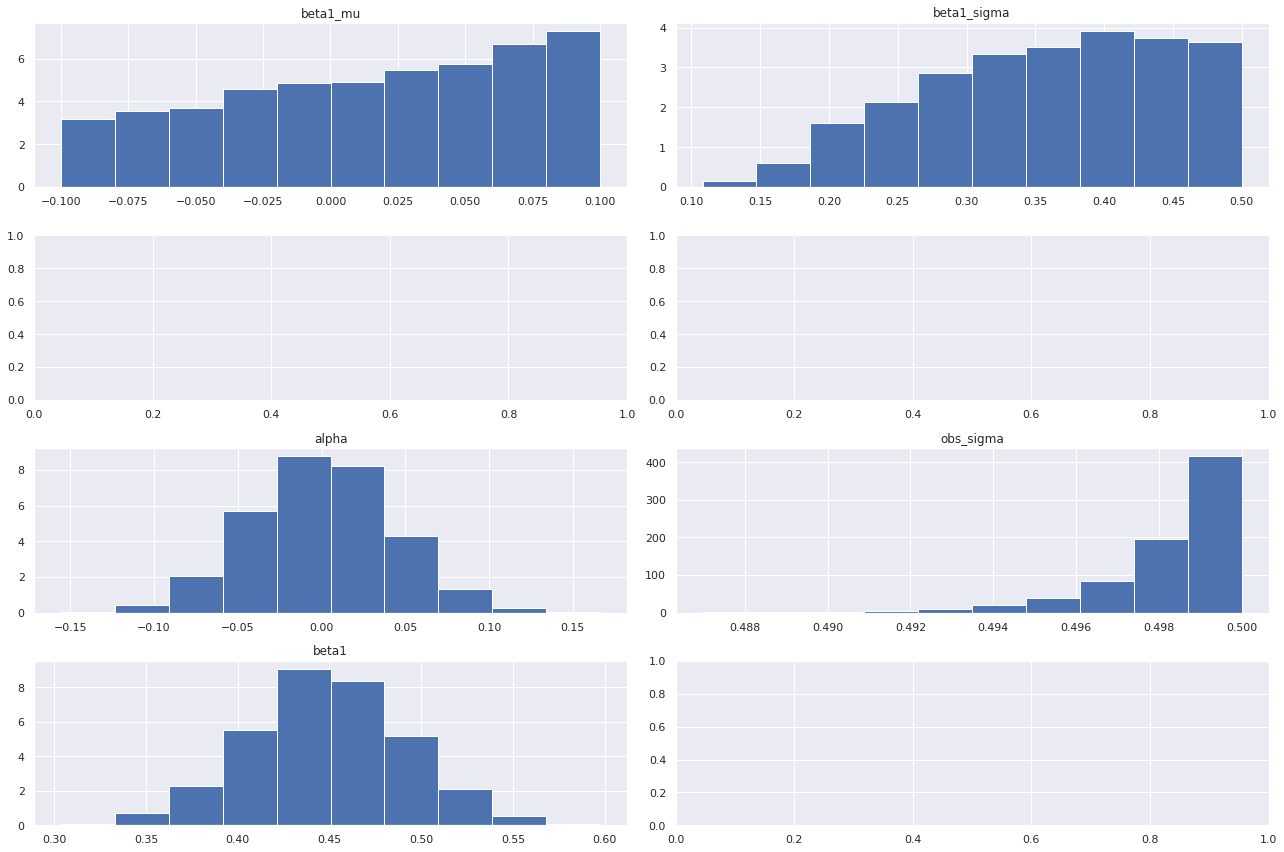

In [29]:
# disable the burn params in mcmc.sample to see the convergence
fig,axes = plt.subplots(4,2,figsize=(18,12))


axes[0,0].plot(result.beta1_mu_post)
axes[0,0].set_title('beta1_mu')
axes[0,1].plot(result.beta1_sigma_post)
axes[0,1].set_title('beta1_sigma')

if multiple_regression:
    axes[1,0].plot(result.beta2_mu_post)
    axes[1,0].set_title('beta2_mu')
    axes[1,1].plot(result.beta2_sigma_post)
    axes[1,1].set_title('beta2_sigma')
    
axes[2,0].plot(result.alpha_post)
axes[2,0].set_title('alpha')
axes[2,1].plot(result.obs_sigma_post)
axes[2,1].set_title('obs_sigma')
axes[3,0].plot(result.beta1_post)
axes[3,0].set_title('beta1')

if multiple_regression:
    axes[3,1].plot(result.beta2_post)
    axes[3,1].set_title('beta2')
    
plt.tight_layout()

fig,axes = plt.subplots(4,2,figsize=(18,12))


axes[0,0].hist(result.beta1_mu_post,density=True)
axes[0,0].set_title('beta1_mu')
axes[0,1].hist(result.beta1_sigma_post,density=True)
axes[0,1].set_title('beta1_sigma')

if multiple_regression:
    
    axes[1,0].hist(result.beta2_mu_post,density=True)
    axes[1,0].set_title('beta2_mu')
    axes[1,1].hist(result.beta2_sigma_post,density=True)
    axes[1,1].set_title('beta2_sigma')
    
axes[2,0].hist(result.alpha_post,density=True)
axes[2,0].set_title('alpha')
axes[2,1].hist(result.obs_sigma_post,density=True)
axes[2,1].set_title('obs_sigma')
axes[3,0].hist(result.beta1_post,density=True)
axes[3,0].set_title('beta1')

if multiple_regression:
    axes[3,1].hist(result.beta2_post,density=True)
    axes[3,1].set_title('beta2')
    
plt.tight_layout()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 57 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1       -0.18  0.04   -0.26    -0.10        0.0      0.0   3521.29   
beta2        0.01  0.28   -0.59     0.59        0.0      0.0   3822.56   
beta1_mu    -0.02  0.06   -0.10     0.08        0.0      0.0   3501.45   
beta1_sigma  0.26  0.12    0.06     0.48        0.0      0.0   2710.89   
beta2_mu     0.00  0.06   -0.09     0.10        0.0      0.0   2544.13   
beta2_sigma  0.25  0.14    0.02     0.48        0.0      0.0   1734.43   
obs_sigma    0.50  0.00    0.50     0.50        0.0      0.0   4340.90   
alpha        0.00  0.04   -0.08     0.08        0.0      0.0   4133.02   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3521.29   3540.91   3135.14    1.0  
beta2        2959.09   3771.19   3861.56    1.0  
beta1_mu     3420.45   3531.44   3877.01    1.0  
beta1_sigma  2710.89   2654.36   3018.50    1.0  
beta2_mu     2544.13   2726.67   3876.14    1.0  
beta2_sigma  1734.43   1660.40   

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 60 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1        0.34  0.04    0.26     0.42        0.0      0.0   3592.60   
beta2       -0.00  0.28   -0.55     0.60        0.0      0.0   3548.73   
beta1_mu     0.01  0.06   -0.08     0.10        0.0      0.0   4154.98   
beta1_sigma  0.33  0.10    0.17     0.50        0.0      0.0   3530.94   
beta2_mu    -0.00  0.06   -0.10     0.09        0.0      0.0   2778.33   
beta2_sigma  0.25  0.14    0.00     0.47        0.0      0.0   1701.34   
obs_sigma    0.50  0.00    0.50     0.50        0.0      0.0   4063.74   
alpha        0.00  0.04   -0.08     0.08        0.0      0.0   4166.80   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3592.60   3596.76   3515.72    1.0  
beta2        2687.98   3585.36   4293.77    1.0  
beta1_mu     3532.27   4054.98   4365.18    1.0  
beta1_sigma  3457.81   3563.59   4411.36    1.0  
beta2_mu     2778.33   2860.44   3986.42    1.0  
beta2_sigma  1701.34   1672.26   

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 41 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1       -0.19  0.04   -0.27    -0.11       0.00      0.0   3638.51   
beta2       -0.00  0.30   -0.61     0.61       0.01      0.0   3288.33   
beta1_mu    -0.02  0.06   -0.10     0.08       0.00      0.0   3512.49   
beta1_sigma  0.27  0.12    0.08     0.49       0.00      0.0   3119.71   
beta2_mu    -0.00  0.06   -0.10     0.09       0.00      0.0   2648.22   
beta2_sigma  0.25  0.15    0.02     0.49       0.00      0.0   1676.45   
obs_sigma    0.50  0.00    0.50     0.50       0.00      0.0   4051.12   
alpha       -0.00  0.04   -0.08     0.08       0.00      0.0   4562.84   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3638.51   3637.53   4057.58    1.0  
beta2        2820.52   3247.73   3739.39    1.0  
beta1_mu     3512.49   3325.75   4136.16    1.0  
beta1_sigma  3119.71   3089.08   3465.36    1.0  
beta2_mu     2648.22   2699.16   3591.83    1.0  
beta2_sigma  1676.45   1629.43   

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
>Metropolis: [alpha]
>Metropolis: [obs_sigma]
>Metropolis: [beta2_sigma]
>Metropolis: [beta2_mu]
>Metropolis: [beta1_sigma]
>Metropolis: [beta1_mu]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 39 seconds.
The number of effective samples is smaller than 10% for some parameters.


             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta1        0.52  0.04    0.44     0.59        0.0      0.0   3647.37   
beta2       -0.01  0.28   -0.55     0.60        0.0      0.0   3453.50   
beta1_mu     0.01  0.06   -0.08     0.10        0.0      0.0   4162.54   
beta1_sigma  0.37  0.08    0.23     0.50        0.0      0.0   3477.87   
beta2_mu    -0.00  0.06   -0.10     0.09        0.0      0.0   2311.06   
beta2_sigma  0.24  0.15    0.00     0.47        0.0      0.0   1700.29   
obs_sigma    0.50  0.00    0.49     0.50        0.0      0.0   4363.91   
alpha        0.00  0.04   -0.08     0.08        0.0      0.0   3824.61   

              ess_sd  ess_bulk  ess_tail  r_hat  
beta1        3631.25   3657.92   4392.99    1.0  
beta2        2561.59   3351.10   3836.92    1.0  
beta1_mu     3639.83   4110.08   4158.33    1.0  
beta1_sigma  3375.44   3231.94   3098.31    1.0  
beta2_mu     2311.06   2409.86   2611.94    1.0  
beta2_sigma  1700.29   1651.57   

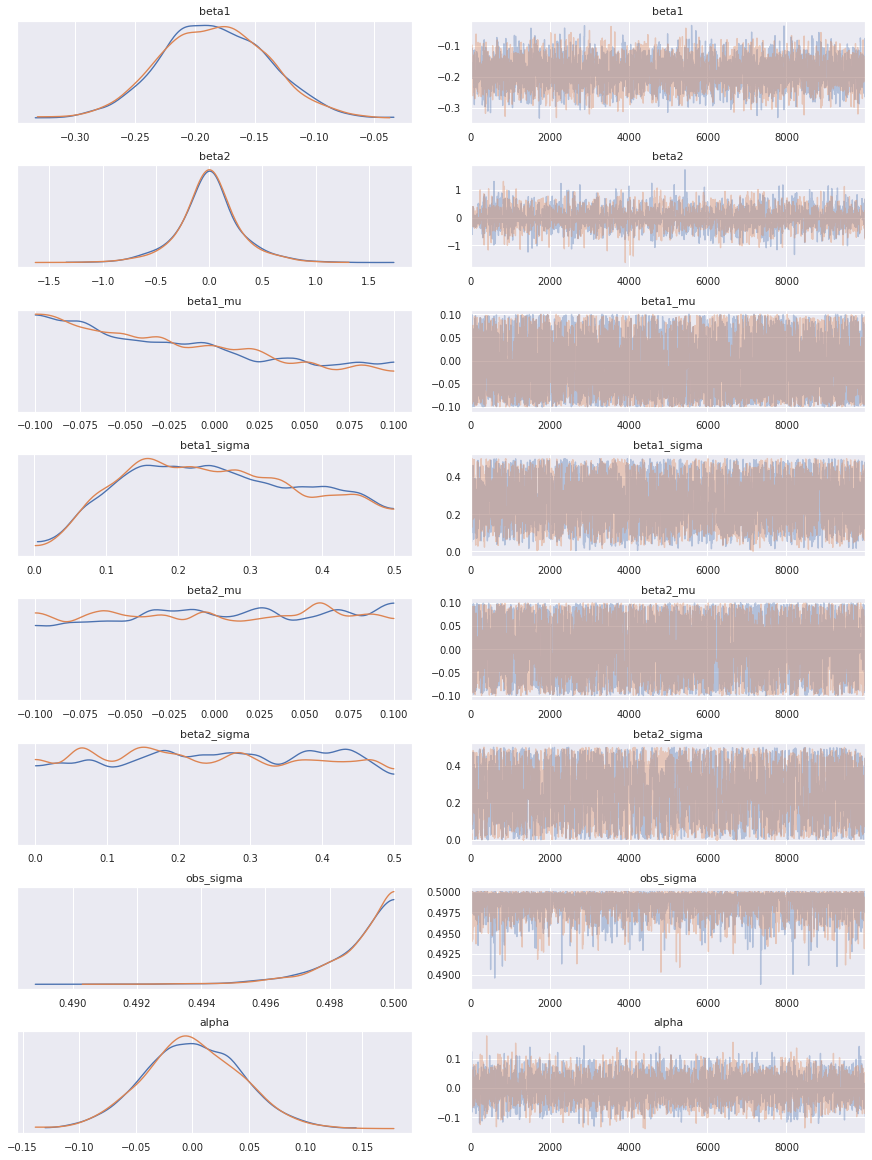

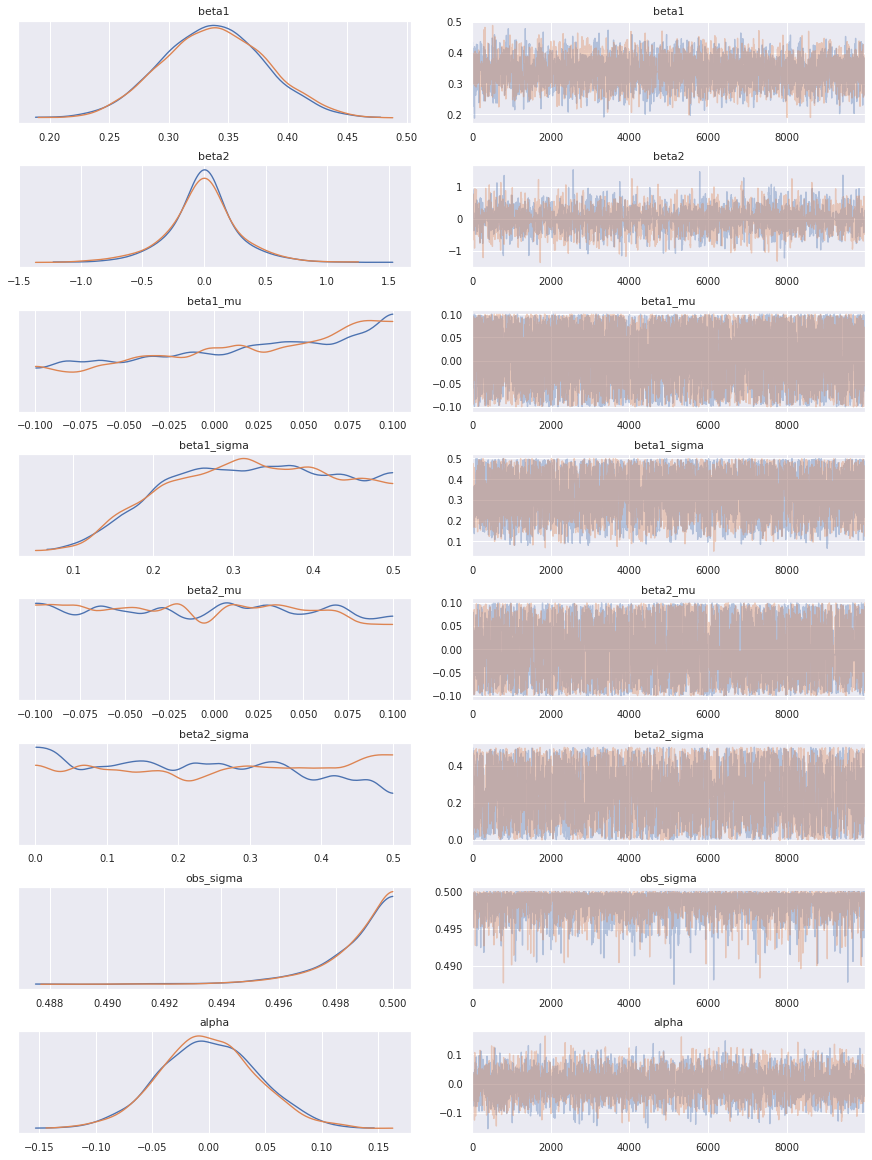

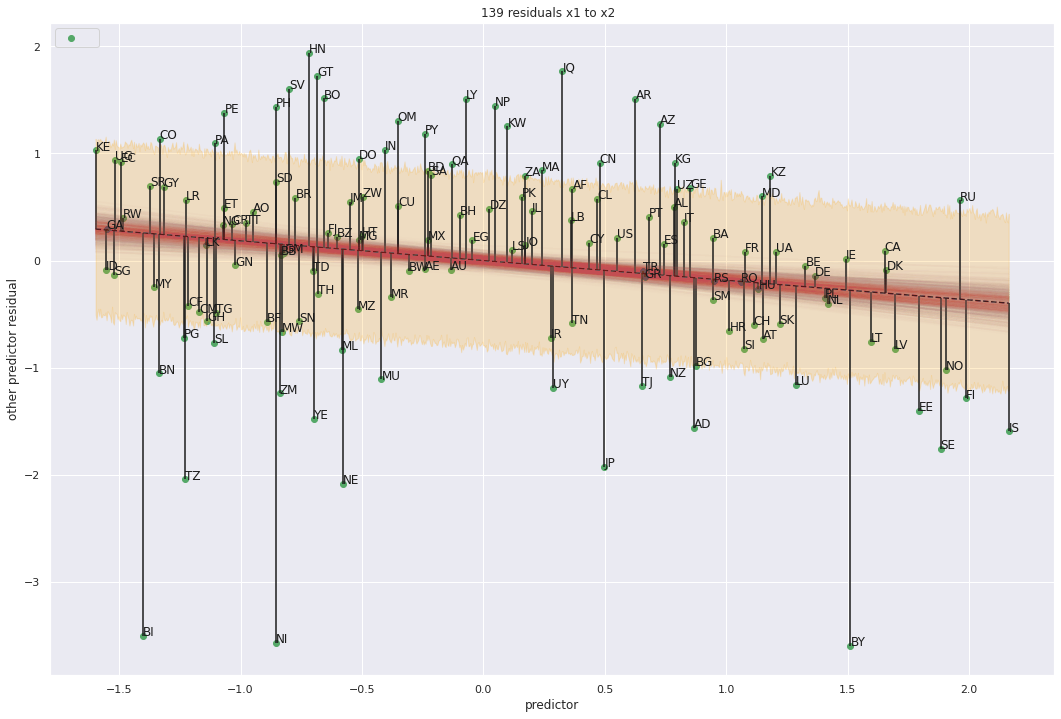

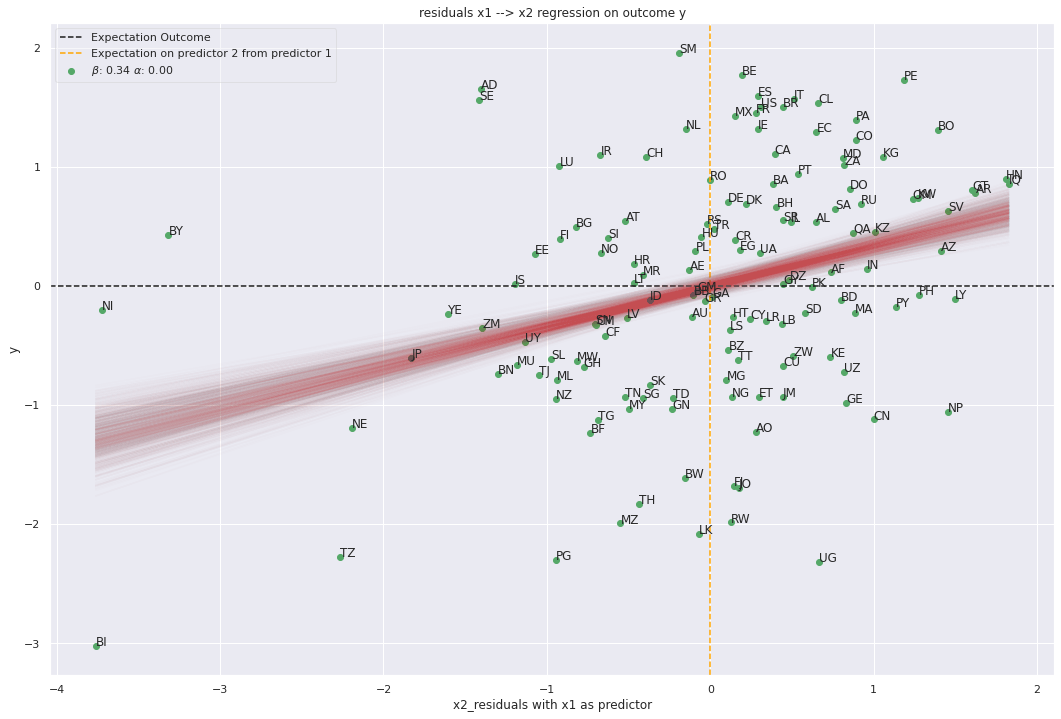

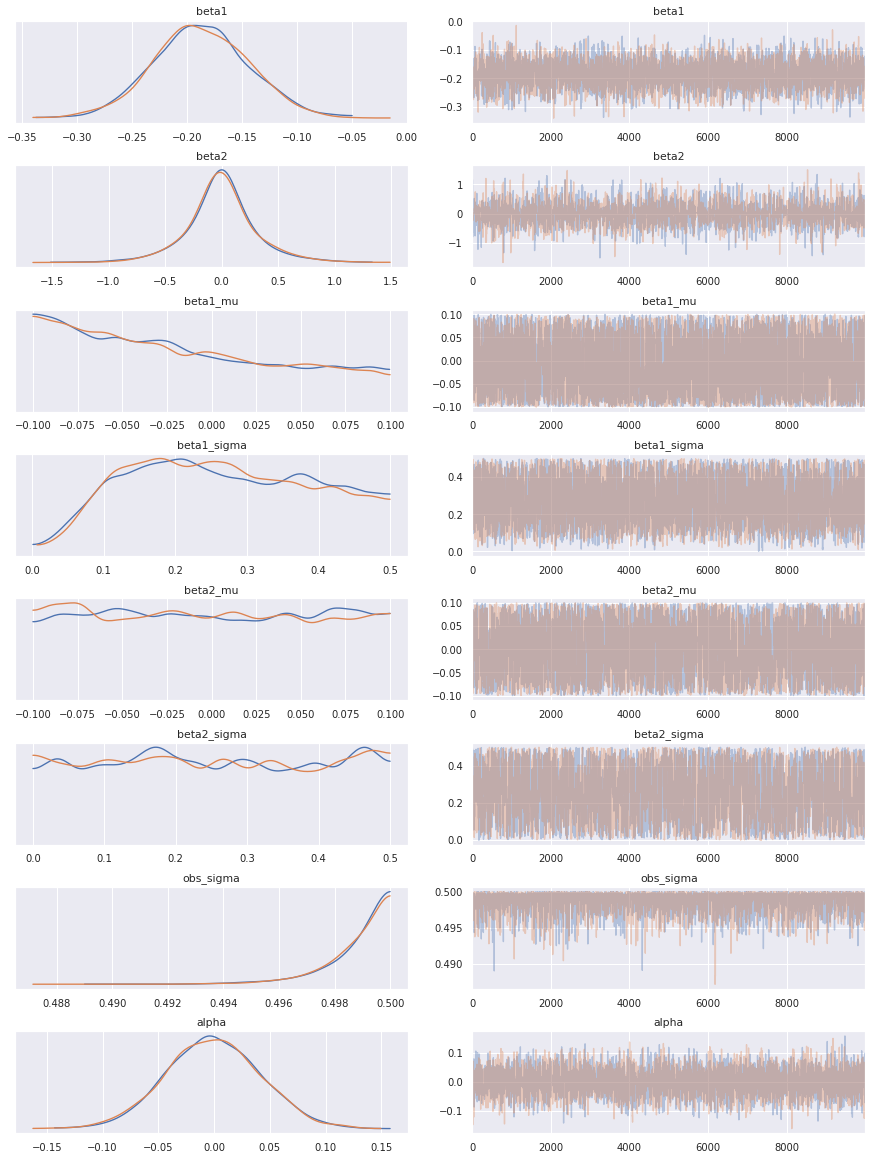

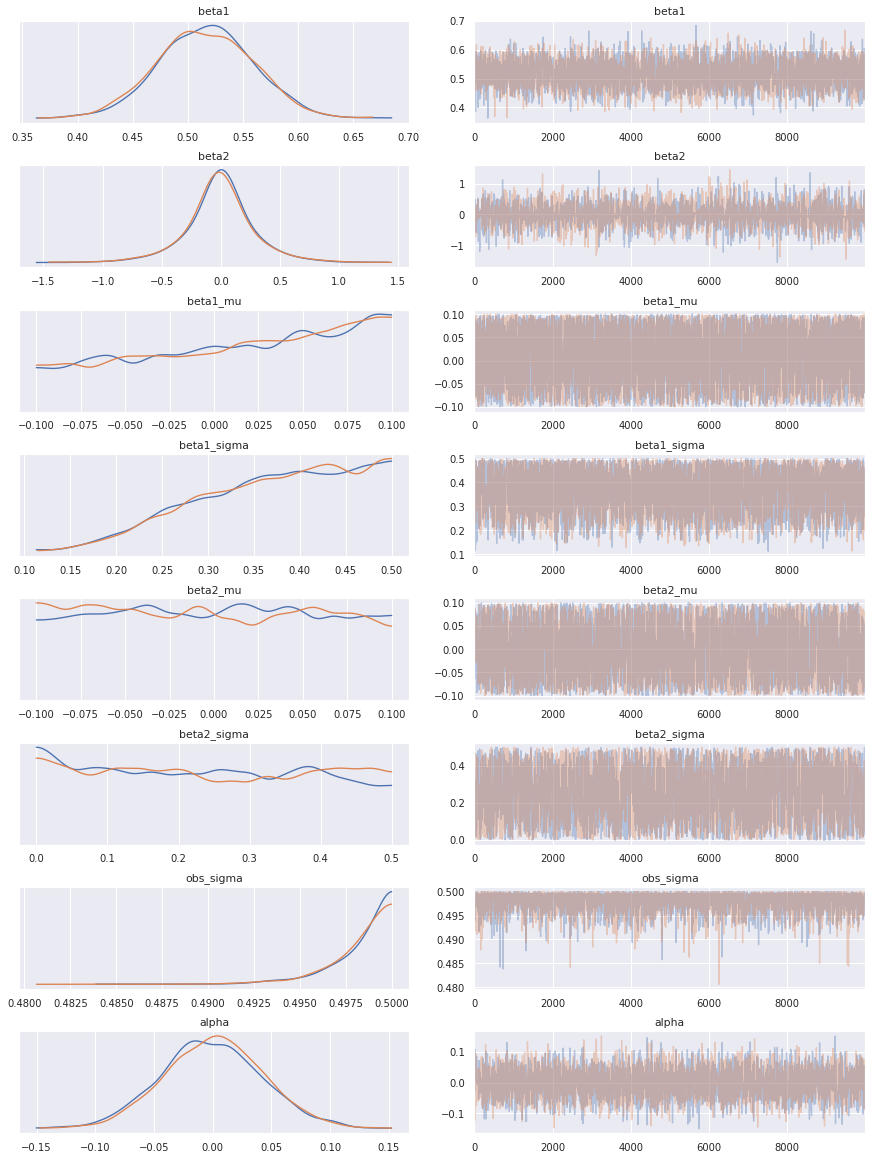

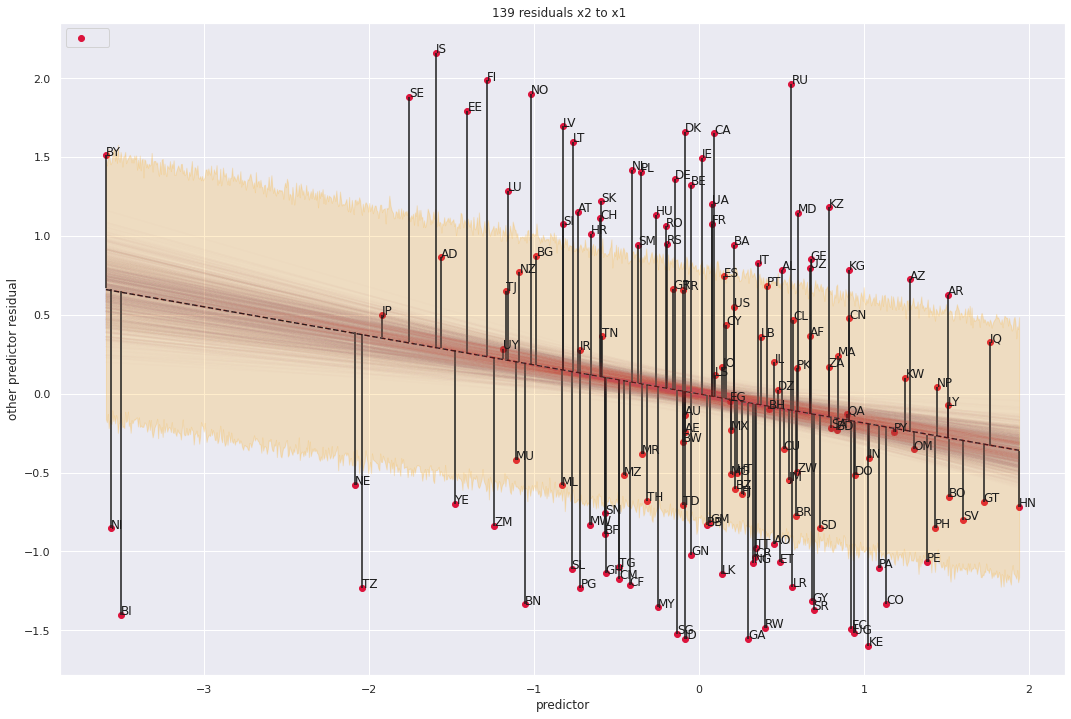

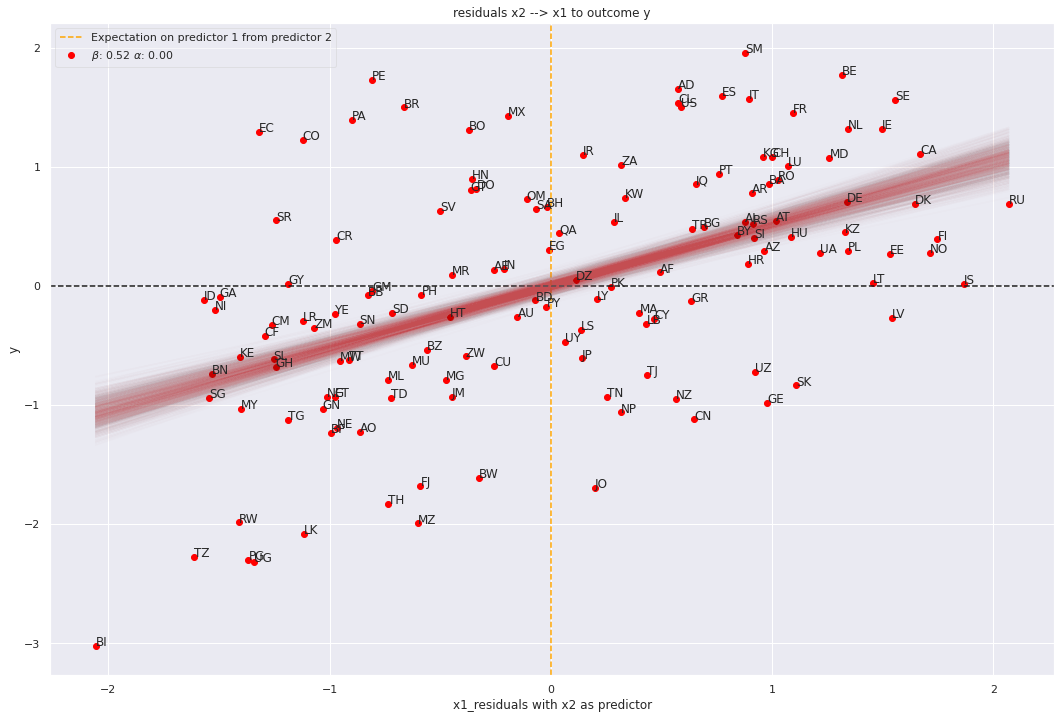

In [30]:
multiple_regression = False


#########
result_x1_x2 = regression(xy['x1_std'],xy['x1_std'],xy['x2_std'])

mean_ys = xy['x1_std'] * result_x1_x2.beta1_post.mean() + result_x1_x2.alpha_post.mean()

low_error = np.zeros_like(xy['x1_std'])
high_error = np.zeros_like(xy['x1_std'])

for i in range(len(low_error)):
    
    if xy['x2_std'].iloc[i] < mean_ys[i]:
        low_error[i] = np.abs(xy['x2_std'].iloc[i] - mean_ys[i])
        high_error[i] = 0
    else:
        high_error[i] = np.abs(xy['x2_std'].iloc[i] - mean_ys[i])
        low_error[i] = 0

residuals_x1_x2 = pd.DataFrame({0 : -1 * low_error + high_error})

if US_states or World_countries:
    residuals_x1_x2.index = xy.index

temp = pd.DataFrame({'predictor': xy['x1_std'],
                    'residual' : residuals_x1_x2[0]})

print()
print (temp.head(50))
print()



result_residuals_x1_x2 = regression(residuals_x1_x2[0],residuals_x1_x2[0], xy['y_std'])

plot(result_x1_x2,xy['x1_std'],xy['x1_std'],xy['x2_std'],
     'residuals x1 to x2',len(xy),xy,create_figure=True,residuals=True,color='g')


plt.errorbar(x=xy['x1_std'],
             y=mean_ys,
             color='k',ls='dashed',fmt='none', yerr= np.array((low_error,high_error)))

plt.savefig('residuals_x1_to_x2.jpg',format='jpg')
           

####
plt.figure(figsize=(18,12))
plt.title('residuals x1 --> x2 regression on outcome y')

plt.scatter(residuals_x1_x2,xy['y_std'],color='g',
            label=r'$\beta$: {:.2f} $\alpha$: {:.2f}'.format(result_residuals_x1_x2.beta1_post.mean(),
                                                            result_residuals_x1_x2.alpha_post.mean()))

plt.axhline(0,color='k',ls='dashed',label='Expectation Outcome')
plt.axvline(0,color='orange',ls='dashed',label='Expectation on predictor 2 from predictor 1')

if US_states or World_countries:
    for s in residuals_x1_x2.index:
        plt.text(residuals_x1_x2.loc[s,0] + 0.001,xy.loc[s,'y_std'] + 0.001,us_abb.loc[s,'abb'])
    
nr_lines = 1000

X = np.linspace(residuals_x1_x2[0].min(),residuals_x1_x2[0].max(),nr_lines)

rows = np.random.choice(result_residuals_x1_x2.index,replace=True,size=nr_lines)

lines = [X[i] * result_residuals_x1_x2.beta1_post[rows] + result_residuals_x1_x2.alpha_post[rows] for i in range(len(X))]


plt.plot(X,lines,alpha=0.01,color='r')  

plt.xlabel('x2_residuals with x1 as predictor')
plt.ylabel('y')

plt.legend(loc='upper left',framealpha=0.4)
plt.savefig('residuals_regression_outcome_plot_x1_x2.jpg',format='jpg')

#########
result_x2_x1 = regression (xy['x2_std'],xy['x2_std'],xy['x1_std'])

mean_ys = xy['x2_std'] * result_x2_x1.beta1_post.mean() + result_x2_x1.alpha_post.mean()

low_error = np.zeros_like(xy['x2_std'])
high_error = np.zeros_like(xy['x2_std'])

for i in range(len(low_error)):
    
    if xy['x1_std'].iloc[i] < mean_ys[i]:
        low_error[i] = np.abs(xy['x1_std'].iloc[i] - mean_ys[i])
        high_error[i] = 0
    else:
        high_error[i] = np.abs(xy['x1_std'].iloc[i] - mean_ys[i])
        low_error[i] = 0

residuals_x2_x1 = pd.DataFrame({0 : -1 * low_error + high_error})

if US_states or World_countries:
    residuals_x2_x1.index = xy.index

temp2 = pd.DataFrame({'predictor': xy['x2_std'],
                    'residual' : residuals_x2_x1[0]})

print()
print (temp2.head(50))
print()


###########################################################################


result_residuals_x2_x1 = regression(residuals_x2_x1[0],residuals_x2_x1[0], xy['y_std'])

plot(result_x2_x1,xy['x2_std'],xy['x2_std'],xy['x1_std'],
     'residuals x2 to x1',len(xy),xy,create_figure=True,residuals=True)


plt.errorbar(x=xy['x2_std'],
             y=mean_ys,
             color='k',ls='dashed',fmt='none', yerr= np.array((low_error,high_error)))

plt.savefig('residuals_x2_to_x1.jpg',format='jpg')

            
####
plt.figure(figsize=(18,12))
plt.title('residuals x2 --> x1 to outcome y')

plt.scatter(residuals_x2_x1,xy['y_std'],color='red',
           label=r'$\beta$: {:.2f} $\alpha$: {:.2f}'.format(result_residuals_x2_x1.beta1_post.mean(),
                                                            result_residuals_x2_x1.alpha_post.mean()))
plt.axhline(0,color='k',ls='dashed')
plt.axvline(0,color='orange',ls='dashed',label='Expectation on predictor 1 from predictor 2')

if US_states or World_countries:
    for s in residuals_x2_x1.index:
        plt.text(residuals_x2_x1.loc[s,0] ,xy.loc[s,'y_std'] ,us_abb.loc[s,'abb'])
    
X = np.linspace(residuals_x2_x1[0].min(),residuals_x2_x1[0].max(),nr_lines)

rows = np.random.choice(result_residuals_x2_x1.index,replace=True,size=nr_lines)

lines = [X[i] * result_residuals_x2_x1.beta1_post[rows] + result_residuals_x2_x1.alpha_post[rows] for i in range(len(X))]

plt.plot(X,lines,alpha=0.01,color='r')  
    
plt.xlabel('x1_residuals with x2 as predictor')
plt.ylabel('y')
plt.legend(loc='upper left',framealpha=0.4)

plt.savefig('residuals_regression_outcome_plot_x2_x1.jpg',format='jpg')

                  0
Iraq       1.826200
Honduras   1.808584
Argentina  1.622630
Guatemala  1.600455
Libya      1.494978
...             ...
Niger     -2.194225
Tanzania  -2.268464
Belarus   -3.317046
Nicaragua -3.723759
Burundi   -3.761551

[139 rows x 1 columns]


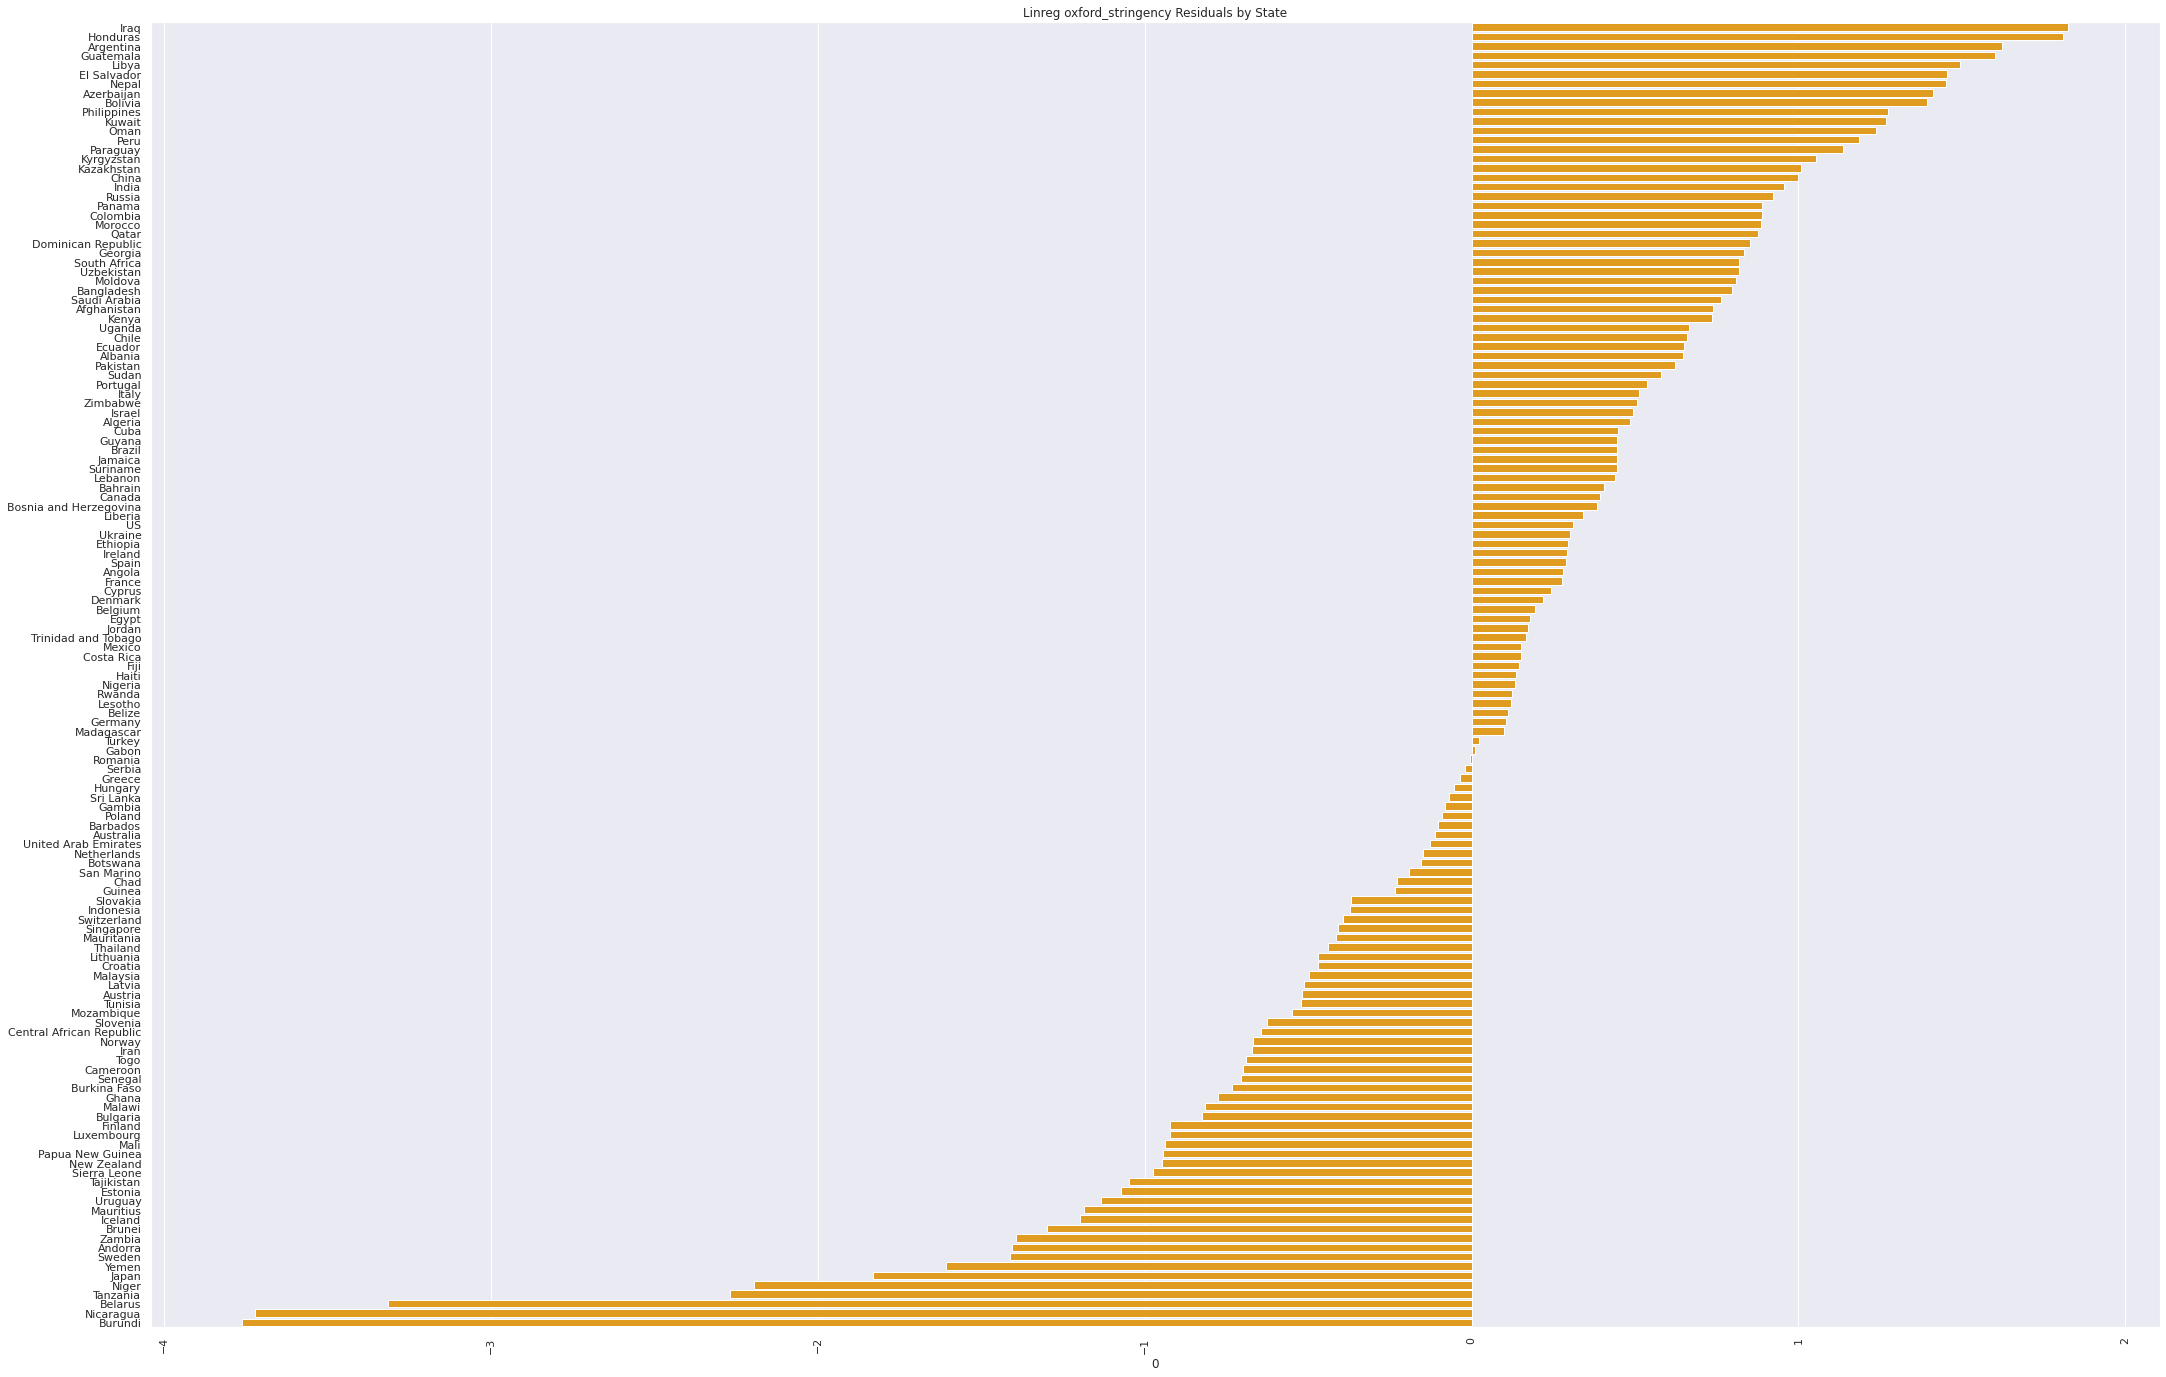

In [31]:
if US_states or World_countries:
    plt.figure(figsize=(36,24))
    plt.title('Linreg {} Residuals by State'.format(x2_param))
    residuals_x1_x2.sort_values(0,inplace=True,ascending=False)
    b = sns.barplot(data=residuals_x1_x2,y=residuals_x1_x2.index,x=0,palette=['orange'])
    plt.xticks(rotation=90)
    plt.savefig('linreg_{}_residuals_by_state.jpg'.format(x2_param))
    print (residuals_x1_x2)

                  0
Iraq       1.826200
Honduras   1.808584
Argentina  1.622630
Guatemala  1.600455
Libya      1.494978
...             ...
Niger     -2.194225
Tanzania  -2.268464
Belarus   -3.317046
Nicaragua -3.723759
Burundi   -3.761551

[139 rows x 1 columns]


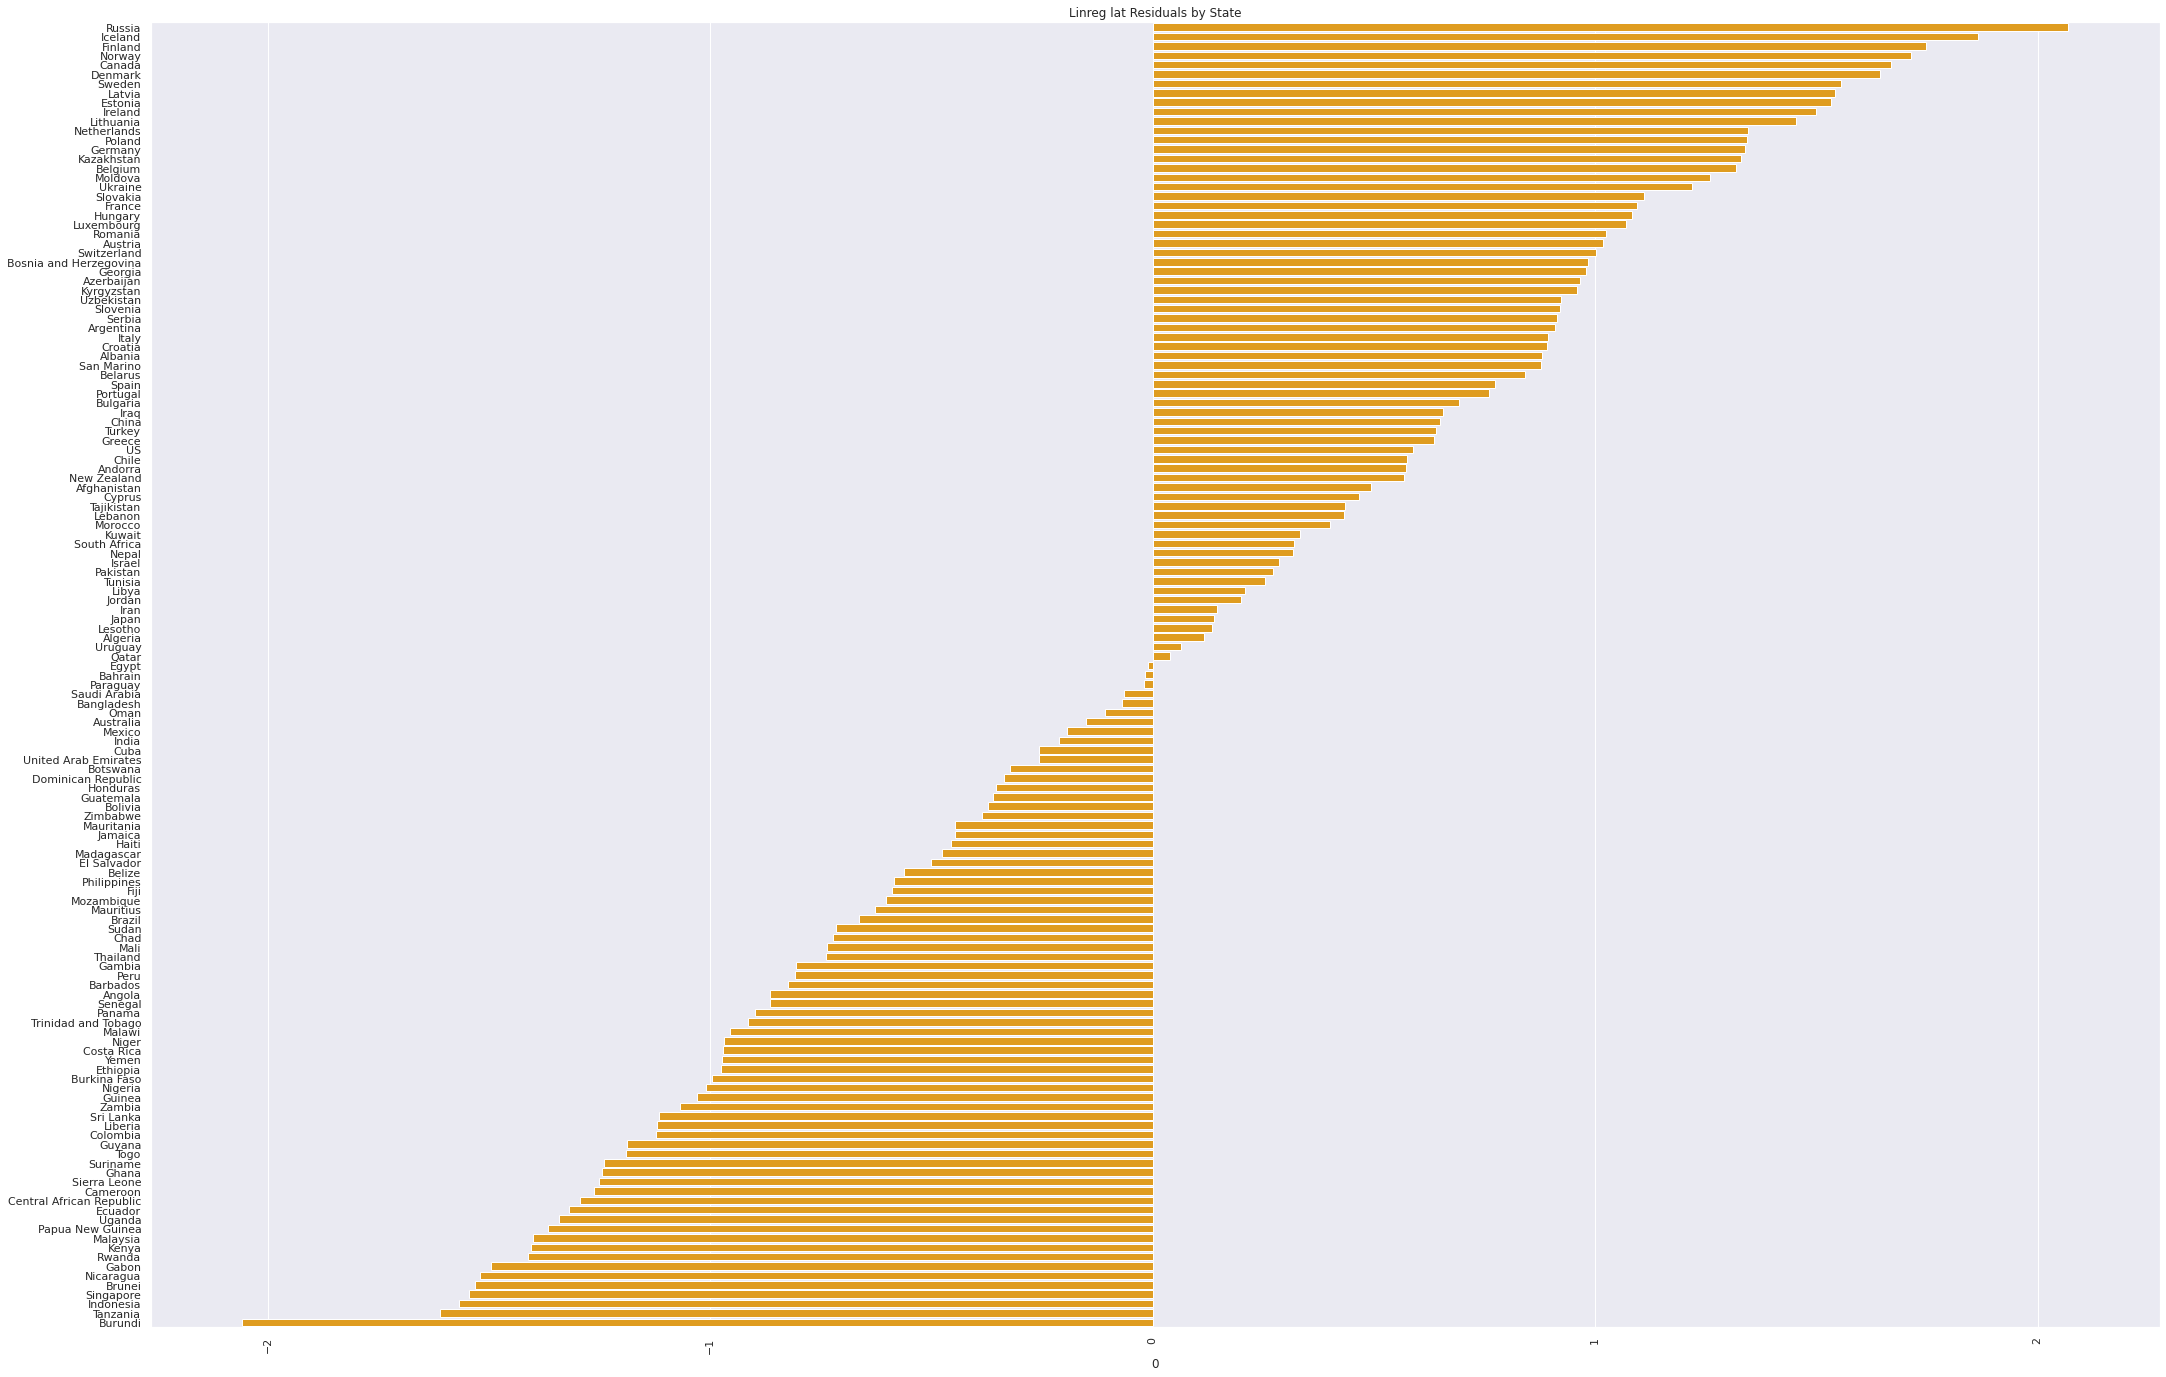

In [32]:
if US_states or World_countries:
    plt.figure(figsize=(36,24))
    plt.title('Linreg {} Residuals by State'.format(x1_param))
    residuals_x2_x1.sort_values(0,inplace=True,ascending=False)
    sns.barplot(data=residuals_x2_x1,y=residuals_x2_x1.index,x=0,palette=['orange'])
    plt.xticks(rotation=90)
    plt.savefig('linreg_{}_residuals_by_state.jpg'.format(x1_param))
    print (residuals_x1_x2)

In [ ]:
### counterfactual plots

### x1 to mean values
xy['x1_std'] = xy['x1_std'].mean() # array of zeros since we deal with standardized variables

multiple_regression = True
result_counterfactual_x1 = regression(xy['x1_std'], xy['x2_std'],xy['y_std'])

plot(result_counterfactual_x1,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'counterfactuals_x1 to outcome',len(xy),xy,create_figure=True)

In [ ]:
xy = xy_orig.copy()

### x2 to mean values
xy['x2_std'] = xy['x2_std'].mean() # array of zeros since we deal with standardized variables

multiple_regression = True
result_counterfactual_x2 = regression(xy['x1_std'], xy['x2_std'],xy['y_std'])

plot(result_counterfactual_x2,xy['x1_std'],xy['x2_std'],xy['y_std'],
     'counterfactuals_x2 to outcome',len(xy),xy,create_figure=True)



In [ ]:
### Posterior prediction plot

xy = xy_orig.copy()

nr_samples = 10000

rows = np.random.choice(result.index,replace=True,size=nr_samples)
samples = result.iloc[rows]
print (samples)

alpha_samples = samples['alpha_post']
beta1_samples = samples['beta1_post']
beta2_samples = samples['beta2_post']
sigma_samples = samples['obs_sigma_post']

X1 = xy['x1_std']
X2 = xy['x2_std']

posterior_samples = np.array([pm.Normal.dist(X1[i] * beta1_samples + X2[i] * beta2_samples + alpha_samples,
                                        sigma_samples ).random(size=nr_samples) for i in range(len(X1))])

print (posterior_samples.shape)

samples_89 = np.percentile(posterior_samples,[5.5,94.4],axis=1)
print (samples_89.mean(axis=1))
print ()


plt.figure(figsize=(18,12))
plt.title('Posterior Prediction Plot  - actual outcome data points vs simulated')

plt.scatter(xy['y_std'],posterior_samples.mean(axis=1),color='orange')

plt.xlabel('outcome: {}'.format(y_param))
plt.ylabel('posterior mean outcome samples')


plt.errorbar(x=xy['y_std'],
             y=posterior_samples.mean(axis=1),ecolor='lightgrey',capsize=5,
             yerr=np.array((np.abs(posterior_samples.mean(axis=1) - samples_89[0]), 
                            np.abs(posterior_samples.mean(axis=1) - samples_89[1]))),fmt='none')

plt.plot(np.linspace(xy['y_std'].min(),
                     xy['y_std'].max(),100),np.linspace(xy['y_std'].min(),xy['y_std'].max(),100),
         color='k',ls='dashed')


for i,s in enumerate(xy.index):
    plt.text(xy['y_std'].loc[s] ,(posterior_samples.mean(axis=1))[i] ,us_abb.loc[s,'abb'])
    

    
plt.savefig('regression_posterior_plot_{}.jpg'.format(y_param),format='jpg')
    